In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

import torchvision
from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dataloader import *

import torchsnooper

In [2]:
# config part, to init some paths, variables and so on
window_size = 30 # 30 for Yahoo! 120 for KPIs
window_count = 300 # 300 for Yahoo! 256 for KPIs
h_dim = 24 # 24 for Yahoo! 100 for KPIs
z_dim = 5
l_h_dim = h_dim
data_split_rate = 0.5
epochs = 250
lr = 1e-3
lr_decay = 0.8 # decay every 10 epoch, 0.8 for Yahoo!, 0.75 for KPIs
lamb = 10 # 10 for Yahoo!, 1 for KPIs
clip_norm_value = 12.0 # 12.0, 10.0
bs = 1

In [3]:
'''
How to do gradient clip?

optimizer.zero_grad()
loss, hidden = model(data, hidden, targets)
loss.backward()

torch.nn.utils.clip_grad_norm(model.parameters(), clip_norm_value)

optimizer.step()

'''

'''
How to do L2-regularization, which also called weight_decay?

if args.Adam is True:
    print("Adam Training......")
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr,
                                weight_decay=args.init_weight_decay)


'''

'''
How to make lr decay?

scheduler = StepLR(optimizer, step_size=10, gamma=lr_decay)
for epoch in range(epochs):
    train()
    scheduler.step()

'''

'\nHow to make lr decay?\n\nscheduler = StepLR(optimizer, step_size=10, gamma=lr_decay)\nfor epoch in range(epochs):\n    train()\n    scheduler.step()\n\n'

In [4]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [5]:
class VAE_LSTM(nn.Module):
    def __init__(self, window_size, window_count, h_dim, z_dim, l_h_dim):
        super(VAE_LSTM, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(window_size, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, z_dim * 2),
        )
        
        self.decoder = nn.Sequential(
            
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, window_size)
        )
        
        self.lstm = nn.LSTM(window_size, l_h_dim, 1, batch_first=True)
        
        # fc maybe modified, in single step or the total window_count
        # single step version, I think the fc should be shared, so currently I prefer
        # to use single step version
        self.fc = nn.Linear(l_h_dim, 1)
        
        self.window_size = window_size
        self.window_count = window_count
        
        # window_count version
        # self.fc_list = [nn.Linear(l_h_dim, 1) for _ in range(window_count)]
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = to_var(torch.randn(*mu.size()))
        z = mu + std * esp
        return z
    
    # @torchsnooper.snoop()
    def forward(self, x):
        '''
        x:[batch, window_count, window_size]
        '''
        x = x.view(-1, window_size)
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        x_hat = x_hat.view(-1, window_count, window_size)
        
        output, (hn, cn) = self.lstm(x_hat)
        # output : [batch_size, seq_len, l_h_dim]
        y_hat = self.fc(output)

        return x_hat, mu, logvar, y_hat
        

In [6]:
# from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter('runs/VAE_LSTM_exp_1')

### For training

In [7]:
vae_lstm = VAE_LSTM(window_size, window_count, h_dim, z_dim, l_h_dim)
vae_lstm

VAE_LSTM(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=30, bias=True)
  )
  (lstm): LSTM(30, 24, batch_first=True)
  (fc): Linear(in_features=24, out_features=1, bias=True)
)

In [8]:
# loading data
'''
convert to time series into
x: [batch, window_count, window_size]
'''

'\nconvert to time series into\nx: [batch, window_count, window_size]\n'

In [9]:
train_data, train_label, test_data, test_label = load_yahoo('ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_1.csv', window_size, window_count, data_split_rate, use_norm=False)

data info:
(2, 300, 30)
(2, 300)
(2, 300, 30)
(2, 300)


In [10]:
train_data = torch.from_numpy(train_data)
train_label = torch.from_numpy(train_label)
test_data = torch.from_numpy(test_data)
test_label = torch.from_numpy(test_label)

In [11]:
# writer.add_graph(vae_lstm, train_data[:2])

In [12]:
# writer.close()

In [13]:
# output = vae_lstm(train_data[0:2])

In [14]:
# for i in range(4):
#     print(output[i].shape)

In [15]:
# output[-1].squeeze(dim=-1).shape

In [16]:
# train_data[0:1].shape

In [17]:
# train_label[0:1].shape

In [18]:
optimizer = torch.optim.Adam(vae_lstm.parameters(), lr=1e-3)

In [19]:
def loss_fn(x_hat, x, mu, logvar, y_hat, label):
    mse_x = F.mse_loss(x_hat, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp())
    y_hat = y_hat.squeeze(dim=-1)
    mse_y = F.mse_loss(y_hat, label)
    return mse_x + KLD + mse_y


def loss_vae(x_hat, x, mu, logvar):
    mse_x = F.mse_loss(x_hat, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp())
    return mse_x + KLD

In [20]:
scheduler = StepLR(optimizer, step_size=10, gamma=lr_decay)

In [21]:
for epoch in range(epochs):
    for i in range(train_data.shape[0]):
        optimizer.zero_grad()
        

        x_hat, mu, logvar, y_hat = vae_lstm(train_data[i:i+1])
#         x_hat, mu, logvar = vae_lstm(train_data[i:i+1])
        loss = loss_fn(x_hat, train_data[i:i+1], mu, logvar, y_hat, train_label[i:i+1])
#         loss = loss_vae(x_hat, train_data[i:i+1], mu, logvar)
        loss.backward()

        torch.nn.utils.clip_grad_norm(vae_lstm.parameters(), clip_norm_value)
        optimizer.step()
        
        # if i % 100 == 0:
        print("Epoch[{}/{}] Loss: {:.3f}".format(epoch + 1, epochs, loss.item() / bs))
    
    scheduler.step()

D:\python_anaconda\anaconda\lib\site-packages\ipykernel_launcher.py:12: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if sys.path[0] == '':


Epoch[1/250] Loss: 15.570
Epoch[1/250] Loss: 14.911
Epoch[2/250] Loss: 14.077
Epoch[2/250] Loss: 13.586
Epoch[3/250] Loss: 12.755
Epoch[3/250] Loss: 12.380
Epoch[4/250] Loss: 11.557
Epoch[4/250] Loss: 11.288
Epoch[5/250] Loss: 10.476
Epoch[5/250] Loss: 10.285
Epoch[6/250] Loss: 9.495
Epoch[6/250] Loss: 9.368
Epoch[7/250] Loss: 8.599
Epoch[7/250] Loss: 8.522
Epoch[8/250] Loss: 7.762
Epoch[8/250] Loss: 7.733
Epoch[9/250] Loss: 6.987
Epoch[9/250] Loss: 6.996
Epoch[10/250] Loss: 6.255
Epoch[10/250] Loss: 6.300
Epoch[11/250] Loss: 5.565
Epoch[11/250] Loss: 5.712
Epoch[12/250] Loss: 5.044
Epoch[12/250] Loss: 5.209
Epoch[13/250] Loss: 4.538
Epoch[13/250] Loss: 4.730
Epoch[14/250] Loss: 4.064
Epoch[14/250] Loss: 4.274
Epoch[15/250] Loss: 3.610
Epoch[15/250] Loss: 3.838
Epoch[16/250] Loss: 3.185
Epoch[16/250] Loss: 3.432
Epoch[17/250] Loss: 2.786
Epoch[17/250] Loss: 3.047
Epoch[18/250] Loss: 2.421
Epoch[18/250] Loss: 2.690
Epoch[19/250] Loss: 2.088
Epoch[19/250] Loss: 2.362
Epoch[20/250] Loss: 

In [22]:
torch.save(vae_lstm.state_dict(), './models/vaelstm.pt')

### For Test:
- firstly, use train_data to feed into the model, get the reconstructed series
- calculate the standard deviation of the squared error between the last step within x and x_hat, then we get the $\sigma_r$
- find the k to maximize F1 score, then we get the threshold.

In [23]:
test_model = VAE_LSTM(window_size, window_count, h_dim, z_dim, l_h_dim)

In [24]:
test_model.load_state_dict(torch.load('./models/vaelstm.pt'))

<All keys matched successfully>

In [25]:
test_model.eval()

VAE_LSTM(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=30, bias=True)
  )
  (lstm): LSTM(30, 24, batch_first=True)
  (fc): Linear(in_features=24, out_features=1, bias=True)
)

In [26]:
# train_data, train_label, test_data, test_label = load_yahoo('ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_1.csv', window_size, window_count, data_split_rate)

In [27]:
# train_data = torch.from_numpy(train_data)
# train_label = torch.from_numpy(train_label)
# test_data = torch.from_numpy(test_data)
# test_label = torch.from_numpy(test_label)

In [28]:
recon_x, mu, logvar, y_hat = test_model(train_data)

In [29]:
recon_x.shape

torch.Size([2, 300, 30])

In [30]:
def get_sigma_r(train_data, recon_x):
    x = train_data.view(-1, window_size).detach().numpy()
    x_hat = recon_x.view(-1, window_size).detach().numpy()
    diff = x[:, -1] - x_hat[:, -1]
    print(diff.shape)
    sqe = np.array([item ** 2 for item in diff])
    print(sqe.shape)
    std = np.std(sqe)
    return std

In [31]:
sigma_r = get_sigma_r(train_data, recon_x)

(600,)
(600,)


In [32]:
sigma_r

0.005176028285651033

In [33]:
@torchsnooper.snoop()
def reconstruct(model, data):
    data.view(-1, window_size)
    h = model.encoder(data)
    mu, logvar = torch.chunk(h, 2, dim=1)
    z = model.reparameterize(mu, logvar)
    recon = model.decoder(z)
    return recon

In [34]:
td = train_data[0, 200:201]

In [35]:
res = reconstruct(test_model, td)

Source path:... <ipython-input-33-6bae9c34bb67>
Starting var:.. model = VAE_LSTM(  (encoder): Sequential(    (0): Linear...inear(in_features=24, out_features=1, bias=True))
Starting var:.. data = tensor<(1, 30), float32, cpu>
17:59:44.075592 call         2 def reconstruct(model, data):
17:59:44.083569 line         3     data.view(-1, window_size)
17:59:44.085564 line         4     h = model.encoder(data)
New var:....... h = tensor<(1, 10), float32, cpu, grad>
17:59:44.088556 line         5     mu, logvar = torch.chunk(h, 2, dim=1)
New var:....... mu = tensor<(1, 5), float32, cpu, grad>
New var:....... logvar = tensor<(1, 5), float32, cpu, grad>
17:59:44.093543 line         6     z = model.reparameterize(mu, logvar)
New var:....... z = tensor<(1, 5), float32, cpu, grad>
17:59:44.104513 line         7     recon = model.decoder(z)
New var:....... recon = tensor<(1, 30), float32, cpu, grad>
17:59:44.110499 line         8     return recon
17:59:44.114488 return       8     return recon
Retu

In [36]:
td

tensor([[0.0737, 0.0646, 0.0560, 0.0748, 0.0249, 0.0237, 0.0587, 0.1001, 0.0666,
         0.0705, 0.0988, 0.1180, 0.1008, 0.0532, 0.0993, 0.0473, 0.0913, 0.0386,
         0.0703, 0.0294, 0.0969, 0.1166, 0.1211, 0.2038, 0.0463, 0.1826, 0.0220,
         0.0881, 0.0379, 0.0988]])

In [37]:
res

tensor([[ 0.0509,  0.0379,  0.0570,  0.0701,  0.0729,  0.1147,  0.0782,  0.1241,
          0.0476,  0.0289,  0.0749,  0.0368, -0.0008,  0.0463,  0.1235,  0.0309,
          0.0399,  0.1043,  0.0024,  0.0979,  0.1290,  0.0674,  0.0476,  0.0987,
          0.1141,  0.0623,  0.1260,  0.0783,  0.0380,  0.0733]],
       grad_fn=<AddmmBackward>)

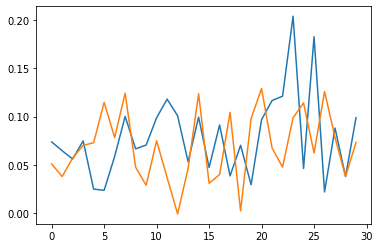

In [38]:
plt.plot(td.detach().numpy()[0])
plt.plot(res.detach().numpy()[0])

Starting var:.. model = VAE_LSTM(  (encoder): Sequential(    (0): Linear...inear(in_features=24, out_features=1, bias=True))
Starting var:.. data = tensor<(1, 30), float32, cpu>
19:30:01.779879 call         2 def reconstruct(model, data):
19:30:01.786861 line         3     data.view(-1, window_size)
19:30:01.788857 line         4     h = model.encoder(data)
New var:....... h = tensor<(1, 10), float32, cpu, grad>
19:30:01.792845 line         5     mu, logvar = torch.chunk(h, 2, dim=1)
New var:....... mu = tensor<(1, 5), float32, cpu, grad>
New var:....... logvar = tensor<(1, 5), float32, cpu, grad>
19:30:01.795837 line         6     z = model.reparameterize(mu, logvar)
New var:....... z = tensor<(1, 5), float32, cpu, grad>
19:30:01.801822 line         7     recon = model.decoder(z)
New var:....... recon = tensor<(1, 30), float32, cpu, grad>
19:30:01.807807 line         8     return recon
19:30:01.811798 return       8     return recon
Return value:.. tensor<(1, 30), float32, cpu, grad>


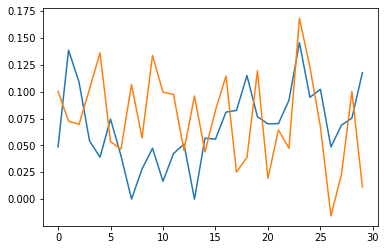

In [39]:
td = train_data[0, 100:101]
res = reconstruct(test_model, td)
plt.plot(td.detach().numpy()[0])
plt.plot(res.detach().numpy()[0])

Starting var:.. model = VAE_LSTM(  (encoder): Sequential(    (0): Linear...inear(in_features=24, out_features=1, bias=True))
Starting var:.. data = tensor<(1, 30), float32, cpu>
19:31:00.532718 call         2 def reconstruct(model, data):
19:31:00.537703 line         3     data.view(-1, window_size)
19:31:00.539697 line         4     h = model.encoder(data)
New var:....... h = tensor<(1, 10), float32, cpu, grad>
19:31:00.542690 line         5     mu, logvar = torch.chunk(h, 2, dim=1)
New var:....... mu = tensor<(1, 5), float32, cpu, grad>
New var:....... logvar = tensor<(1, 5), float32, cpu, grad>
19:31:00.546679 line         6     z = model.reparameterize(mu, logvar)
New var:....... z = tensor<(1, 5), float32, cpu, grad>
19:31:00.553659 line         7     recon = model.decoder(z)
New var:....... recon = tensor<(1, 30), float32, cpu, grad>
19:31:00.558647 line         8     return recon
19:31:00.562636 return       8     return recon
Return value:.. tensor<(1, 30), float32, cpu, grad>


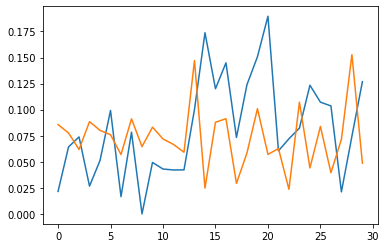

In [40]:
td = train_data[0, 150:151]
res = reconstruct(test_model, td)
plt.plot(td.detach().numpy()[0])
plt.plot(res.detach().numpy()[0])

Starting var:.. model = VAE_LSTM(  (encoder): Sequential(    (0): Linear...inear(in_features=24, out_features=1, bias=True))
Starting var:.. data = tensor<(1, 30), float32, cpu>
19:31:32.758514 call         2 def reconstruct(model, data):
19:31:32.762501 line         3     data.view(-1, window_size)
19:31:32.765495 line         4     h = model.encoder(data)
New var:....... h = tensor<(1, 10), float32, cpu, grad>
19:31:32.769484 line         5     mu, logvar = torch.chunk(h, 2, dim=1)
New var:....... mu = tensor<(1, 5), float32, cpu, grad>
New var:....... logvar = tensor<(1, 5), float32, cpu, grad>
19:31:32.772476 line         6     z = model.reparameterize(mu, logvar)
New var:....... z = tensor<(1, 5), float32, cpu, grad>
19:31:32.777462 line         7     recon = model.decoder(z)
New var:....... recon = tensor<(1, 30), float32, cpu, grad>
19:31:32.782452 line         8     return recon
19:31:32.787436 return       8     return recon
Return value:.. tensor<(1, 30), float32, cpu, grad>


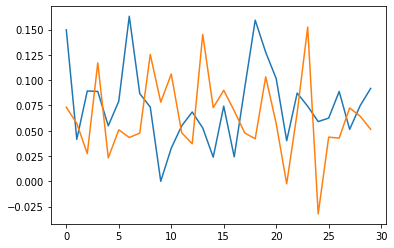

In [41]:
td = train_data[0, 50:51]
res = reconstruct(test_model, td)
plt.plot(td.detach().numpy()[0])
plt.plot(res.detach().numpy()[0])

Starting var:.. model = VAE_LSTM(  (encoder): Sequential(    (0): Linear...inear(in_features=24, out_features=1, bias=True))
Starting var:.. data = tensor<(1, 30), float32, cpu>
19:35:09.953520 call         2 def reconstruct(model, data):
19:35:09.959512 line         3     data.view(-1, window_size)
19:35:09.962494 line         4     h = model.encoder(data)
New var:....... h = tensor<(1, 10), float32, cpu, grad>
19:35:09.964488 line         5     mu, logvar = torch.chunk(h, 2, dim=1)
New var:....... mu = tensor<(1, 5), float32, cpu, grad>
New var:....... logvar = tensor<(1, 5), float32, cpu, grad>
19:35:09.968477 line         6     z = model.reparameterize(mu, logvar)
New var:....... z = tensor<(1, 5), float32, cpu, grad>
19:35:09.974462 line         7     recon = model.decoder(z)
New var:....... recon = tensor<(1, 30), float32, cpu, grad>
19:35:09.980446 line         8     return recon
19:35:09.984434 return       8     return recon
Return value:.. tensor<(1, 30), float32, cpu, grad>


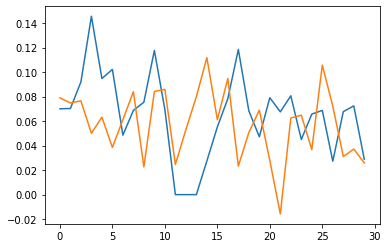

In [42]:
td = train_data[0, 120:121]
res = reconstruct(test_model, td)
plt.plot(td.detach().numpy()[0])
plt.plot(res.detach().numpy()[0])

### 关于VAE重构效果的解释
- 我们采用的数据是Yahoo，论文中说
- Yahoo dataset demonstrate different periodic patterns across the time stamps, it is not suitable for trend prediction evaluation. 
- 这是为什么我们得到的图中，尾部趋势大都并不相符的原因，正是因为数据集体现出这样的特征，导致预测任务在Yahoo数据集上不可做

### Test Predict

In [43]:
test_x_hat, mu, logvar, test_y_hat = test_model(test_data)

In [52]:
test_y_hat.squeeze().shape

torch.Size([2, 300])

In [48]:
test_label.shape

torch.Size([2, 300])

In [53]:
from sklearn.metrics import mean_squared_error

mean_squared_error(test_y_hat.squeeze().detach().numpy(), test_label.detach().numpy())

0.0046720495

In [57]:
origin_series = test_data.detach().numpy()[0, :, -1]
predict_series = test_y_hat.squeeze().detach().numpy()[0]

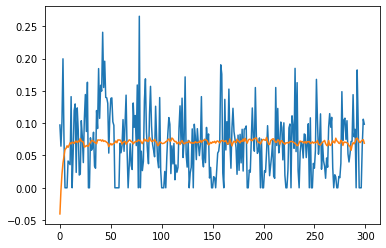

In [60]:
plt.plot(origin_series, label='origin')
plt.plot(predict_series, label='predict')

### 从数值来看，mse在0.004，当然没看到有人用Yahoo做预测，也不知道这个数值到底意味如何，但是从图上来看不适合，进一步的实验结果需要用到KPI数据集，之后如果得到这个数据，可以进一步测试模型正确性

### 异常程度

In [61]:
origin_series = test_data.detach().numpy()[0, :, -1]
recon_series = test_x_hat.detach().numpy()[0, :, -1]
score = origin_series - recon_series
score = np.array([x**2 for x in score])

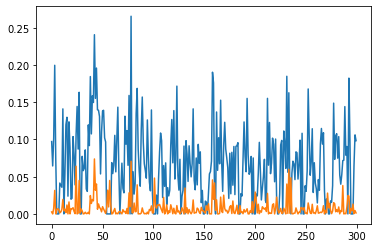

In [64]:
plt.plot(origin_series)
plt.plot(score * 2)

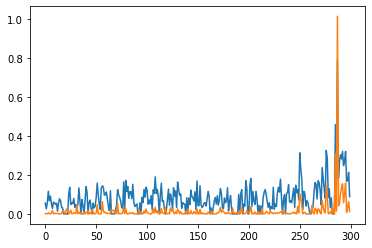

In [65]:
origin_series = test_data.detach().numpy()[1, :, -1]
recon_series = test_x_hat.detach().numpy()[1, :, -1]
score = origin_series - recon_series
score = np.array([x**2 for x in score])
plt.plot(origin_series)
plt.plot(score * 2)

### 从异常检测角度来看，橙色的异常评分和直观感受是契合的。